In [2]:
import numpy as np
import torch
import plotly.graph_objects as go
from binary_btsp_network_torch import BinaryBTSPNetworkTorch 
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

net = BinaryBTSPNetworkTorch(
    n_input=20000,
    n_memory=30000,
    fw=0.6,   # 连接密度
    fq=0.005,  # 学习翻转概率
    fp=0.005,  # 输入模式稀疏度
    threshold=12
)

# 生成训练模式
patterns = net.make_sparse_patterns(n_patterns=30000)

# 训练前：统计突触强度分布
def analyze_synaptic_strength_distribution(network):
    """分析CA1神经元的总突触强度分布"""
    # 计算每个CA1神经元的总突触强度（按行求和）
    total_strengths = network.synaptic_strengths.sum(dim=1).cpu().numpy()
    
    print("\n=== CA1神经元突触强度分布统计 ===")
    print(f"总神经元数量: {len(total_strengths)}")
    print(f"平均总突触强度: {total_strengths.mean():.2f}")
    print(f"标准差: {total_strengths.std():.2f}")
    print(f"最小值: {total_strengths.min():.2f}")
    print(f"最大值: {total_strengths.max():.2f}")
    print(f"中位数: {np.median(total_strengths):.2f}")
    
    # 绘制分布直方图
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=total_strengths,
        nbinsx=50,
        name="突触强度分布",
        opacity=0.7
    ))
    
    fig.update_layout(
        title="CA1神经元总突触强度分布",
        xaxis_title="总突触强度",
        yaxis_title="神经元数量",
        showlegend=False
    )
    
    fig.show()
    
    return total_strengths


In [3]:
# ------------------ 训练前突触分布 ------------------
#print("训练前的突触强度分布:")
#strengths_before = analyze_synaptic_strength_distribution(net)

# ------------------ 训练前记忆测试（任选一个模式可查看） ------------------
memory_before = net.forward(patterns[1])
print("\n=== 训练前记忆测试 ===")
print("训练前 CA1 激活向量（部分）:", memory_before[:50].cpu().numpy())
print("训练前 CA1 激活神经元数量:", memory_before.sum().item())

# ------------------ 对所有模式进行训练 ------------------
print("\n=== 执行BTSP训练（所有模式） ===")
net.train(patterns)

# ------------------ 训练后突触分布 ------------------
print("\n训练后的突触强度分布:")
strengths_after = analyze_synaptic_strength_distribution(net)

# ------------------ 训练后记忆测试（任选一个模式可查看） ------------------
memory_after = net.forward(patterns[1])
print("\n=== 训练后记忆测试 ===")
print("训练后 CA1 激活向量（部分）:", memory_after[:50].cpu().numpy())
print("训练后 CA1 激活神经元数量:", memory_after.sum().item())

# ------------------ 训练前后对比 ------------------
#print("\n=== 训练前后对比 ===")
##strength_change = strengths_after - strengths_before
#print(f"突触强度平均变化: {strength_change.mean():.6f}")
#print(f"突触强度变化标准差: {strength_change.std():.6f}")
#print(f"突触强度增加的数量: {(strength_change > 0).sum()}")
#print(f"突触强度减少的数量: {(strength_change < 0).sum()}")
#print(f"突触强度不变的数量: {(strength_change == 0).sum()}")




=== 训练前记忆测试 ===
训练前 CA1 激活向量（部分）: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
训练前 CA1 激活神经元数量: 0

=== 执行BTSP训练（所有模式） ===

训练后的突触强度分布:

=== CA1神经元突触强度分布统计 ===
总神经元数量: 30000
平均总突触强度: 4660.14
标准差: 59.89
最小值: 4406.00
最大值: 4918.00
中位数: 4660.00



=== 训练后记忆测试 ===
训练后 CA1 激活向量（部分）: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
训练后 CA1 激活神经元数量: 29979


In [ ]:

# 绘制训练前后的对比
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=strengths_before,
    nbinsx=50,
    name="训练前",
    opacity=0.7
))
fig.add_trace(go.Histogram(
    x=strengths_after,
    nbinsx=50,
    name="训练后",
    opacity=0.7
))

fig.update_layout(
    title="训练前后突触强度分布对比",
    xaxis_title="总突触强度",
    yaxis_title="神经元数量",
    barmode='overlay'
)
fig.update_traces(opacity=0.75)
fig.show()

# 绘制突触强度变化分布
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=strength_change,
    nbinsx=50,
    name="突触强度变化",
    opacity=0.7
))

fig.update_layout(
    title="突触强度变化分布",
    xaxis_title="突触强度变化量",
    yaxis_title="神经元数量",
    showlegend=False
)
fig.show()

In [5]:
import torch
import numpy as np
import plotly.graph_objects as go

def analyze_activation_distribution(network: BinaryBTSPNetworkTorch, patterns: torch.Tensor, n_random=1000):
    """
    分析训练后网络激活分布
    
    Args:
        network: 已训练的 BinaryBTSPNetworkTorch 网络
        patterns: 训练模式 (n_patterns, n_input)
        n_random: 随机输入数量
    """
    print("begin")
    # ------------------ 训练模式激活（批量加速） ------------------
    batch_size = 100  # 或根据GPU显存调整
    trained_activations = []

    for i in range(0, patterns.shape[0], batch_size):
        batch = patterns[i:i+batch_size].to(network.device).float()  # (batch_size, n_input)
        
        # 批量前向传播：矩阵乘法 + 阈值
        out = (batch @ network.synaptic_strengths.T >= network.threshold.float()).to(torch.uint8)  # (batch_size, n_memory)
        
        # 统计每个模式的激活CA1神经元数量
        n_active = out.sum(dim=1).cpu().numpy()
        
        trained_activations.extend(n_active)

    trained_activations = np.array(trained_activations)

    
    print("=== 训练模式 CA1 激活分布 ===")
    print(f"平均激活数: {trained_activations.mean():.2f}")
    print(f"标准差: {trained_activations.std():.2f}")
    print(f"最小值: {trained_activations.min()}")
    print(f"最大值: {trained_activations.max()}")
    print(f"中位数: {np.median(trained_activations)}")
    
    # ------------------ 随机输入激活（批量加速） ------------------
    n_input = network.n_input
    batch_size = 100
    random_activations = []

    for i in range(0, n_random, batch_size):
        current_batch_size = min(batch_size, n_random - i)
        
        # 生成浮点型稀疏随机输入
        rand_batch = (torch.rand(current_batch_size, n_input, device=network.device) < network.fp).float()
        
        # 批量前向传播
        out = (rand_batch @ network.synaptic_strengths.T >= network.threshold.float()).to(torch.uint8)
        
        # 统计每个输入模式的激活CA1神经元数量
        n_active = out.sum(dim=1).cpu().numpy()
        
        random_activations.extend(n_active)

    random_activations = np.array(random_activations)


    
    print("\n=== 随机输入 CA1 激活分布 ===")
    print(f"平均激活数: {random_activations.mean():.2f}")
    print(f"标准差: {random_activations.std():.2f}")
    print(f"最小值: {random_activations.min()}")
    print(f"最大值: {random_activations.max()}")
    print(f"中位数: {np.median(random_activations)}")
    
    # ------------------ 绘图 ------------------
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=trained_activations,
        nbinsx=50,
        name="训练模式激活",
        opacity=0.7
    ))
    
    fig.add_trace(go.Histogram(
        x=random_activations,
        nbinsx=50,
        name="随机输入激活",
        opacity=0.7
    ))
    
    fig.update_layout(
        title="CA1 神经元激活数量分布",
        xaxis_title="激活神经元数量",
        yaxis_title="模式/样本数量",
        barmode='overlay'
    )
    
    fig.show()
    
    return trained_activations, random_activations

# ------------------ 使用示例 ------------------
trained_acts, random_acts = analyze_activation_distribution(net, patterns, n_random=1000)


begin


KeyboardInterrupt: 

In [6]:
def analyze_ca1_input_distribution(network, input_pattern):
    """
    统计某个输入下，每个CA1神经元的输入加和分布
    """
    # 确保输入是 float
    inp = input_pattern.to(network.device).float()
    # 计算加和 (不做阈值化)
    h = inp @ network.synaptic_strengths.T   # shape = (n_CA1,)
    h = h.detach().cpu().numpy()

    print("\n=== CA1神经元输入加和统计 ===")
    print(f"CA1 总数: {len(h)}")
    print(f"平均输入: {h.mean():.2f}")
    print(f"标准差: {h.std():.2f}")
    print(f"最小值: {h.min():.2f}")
    print(f"最大值: {h.max():.2f}")
    print(f"中位数: {np.median(h):.2f}")

    # 绘制分布直方图
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=h,
        nbinsx=50,
        name="输入加和分布",
        opacity=0.7
    ))
    fig.update_layout(
        title="CA1神经元输入加和分布",
        xaxis_title="输入加和",
        yaxis_title="神经元数量",
        showlegend=False
    )
    fig.show()

    return h


In [7]:


# 统计输入加和分布
h_values = analyze_ca1_input_distribution(net, patterns[10])



=== CA1神经元输入加和统计 ===
CA1 总数: 30000
平均输入: 17.91
标准差: 3.82
最小值: 5.00
最大值: 34.00
中位数: 18.00


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_btsp_input_distribution(network, patterns, trained_indices, neuron_idx=0, bins=50):
    """
    绘制单个CA1神经元对所有模式的输入加和分布（BTSP版本）
    - network: BinaryBTSPNetworkTorch
    - patterns: 所有输入模式 (torch.Tensor, shape [n_patterns, n_input])
    - trained_indices: list/array，哪些模式被用来训练（plateau potentials）
    - neuron_idx: 要查看的CA1神经元索引
    """
    # 转到正确设备
    patterns = patterns.to(network.device).float()
    
    # 取出该神经元的突触权重向量
    weights = network.synaptic_strengths[neuron_idx]  # shape = [n_input]

    # 计算所有模式的输入加和
    input_sums = (patterns @ weights).detach().cpu().numpy()

    # 划分已训练和未训练模式
    trained_mask = np.zeros(len(patterns), dtype=bool)
    trained_mask[trained_indices] = True

    trained_inputs = input_sums[trained_mask]   # 黄色
    untrained_inputs = input_sums[~trained_mask] # 绿色

    # ---------------- 绘图 ----------------
    plt.figure(figsize=(8,5))
    plt.hist(untrained_inputs, bins=bins, color="green", alpha=0.6, label="未训练")
    plt.hist(trained_inputs, bins=bins, color="yellow", alpha=0.6, label="训练过")
    plt.axvline(network.threshold[neuron_idx].item(), color="red", linestyle="--", label="阈值")


    plt.xlabel("突触输入总和")
    plt.ylabel("记忆数量")
    plt.title(f"CA1神经元 {neuron_idx} 的输入加和分布")
    plt.legend()
    plt.show()

    return trained_inputs, untrained_inputs


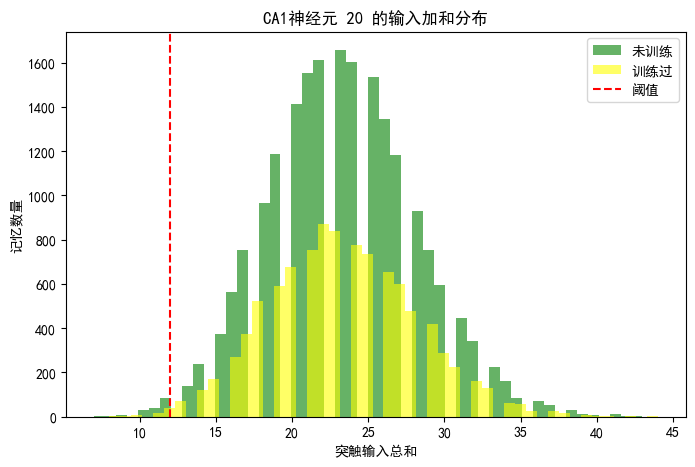

In [6]:
# 假设训练时用了 patterns[:1000] 这 1000 个模式
trained_indices = np.arange(10000)

# 画第 0 个 CA1 神经元的输入分布
trained_inputs, untrained_inputs = plot_btsp_input_distribution(net, patterns, trained_indices, neuron_idx=20)
